# Sentiment Analysis of COVID-19 Vaccine Tweets

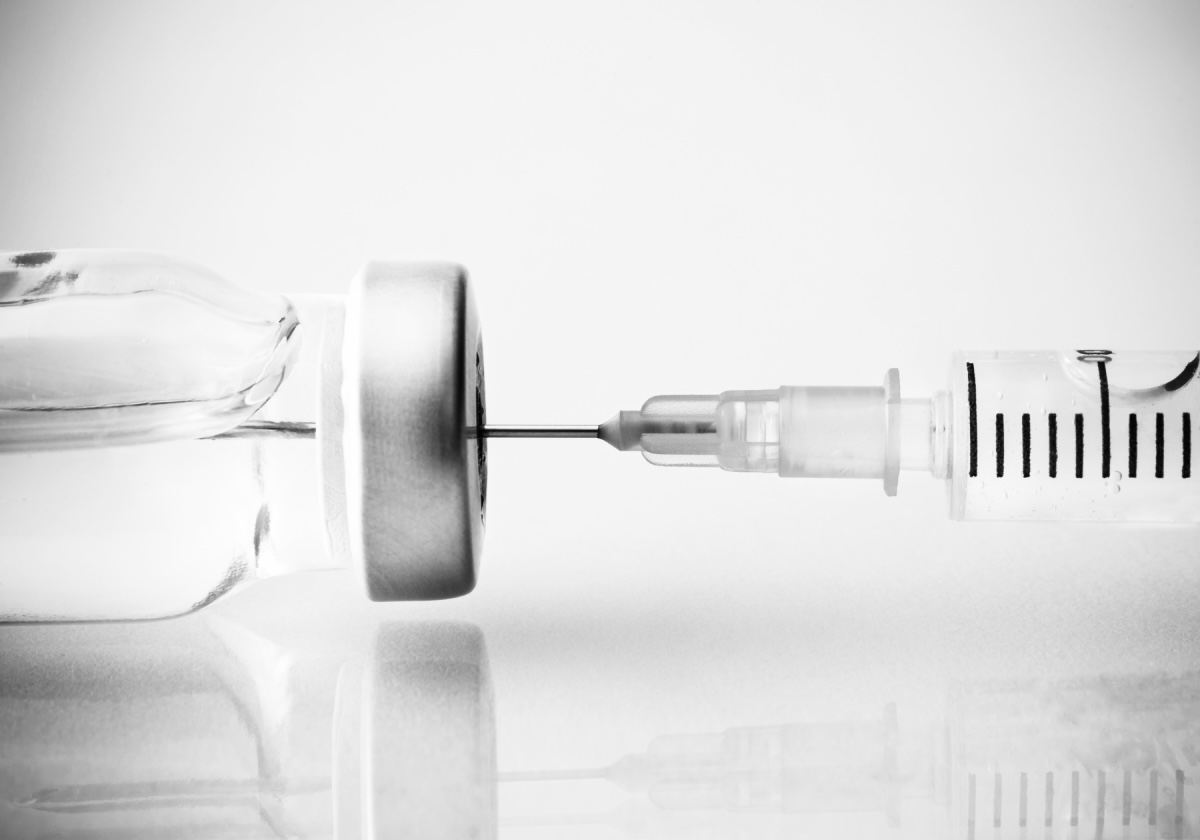

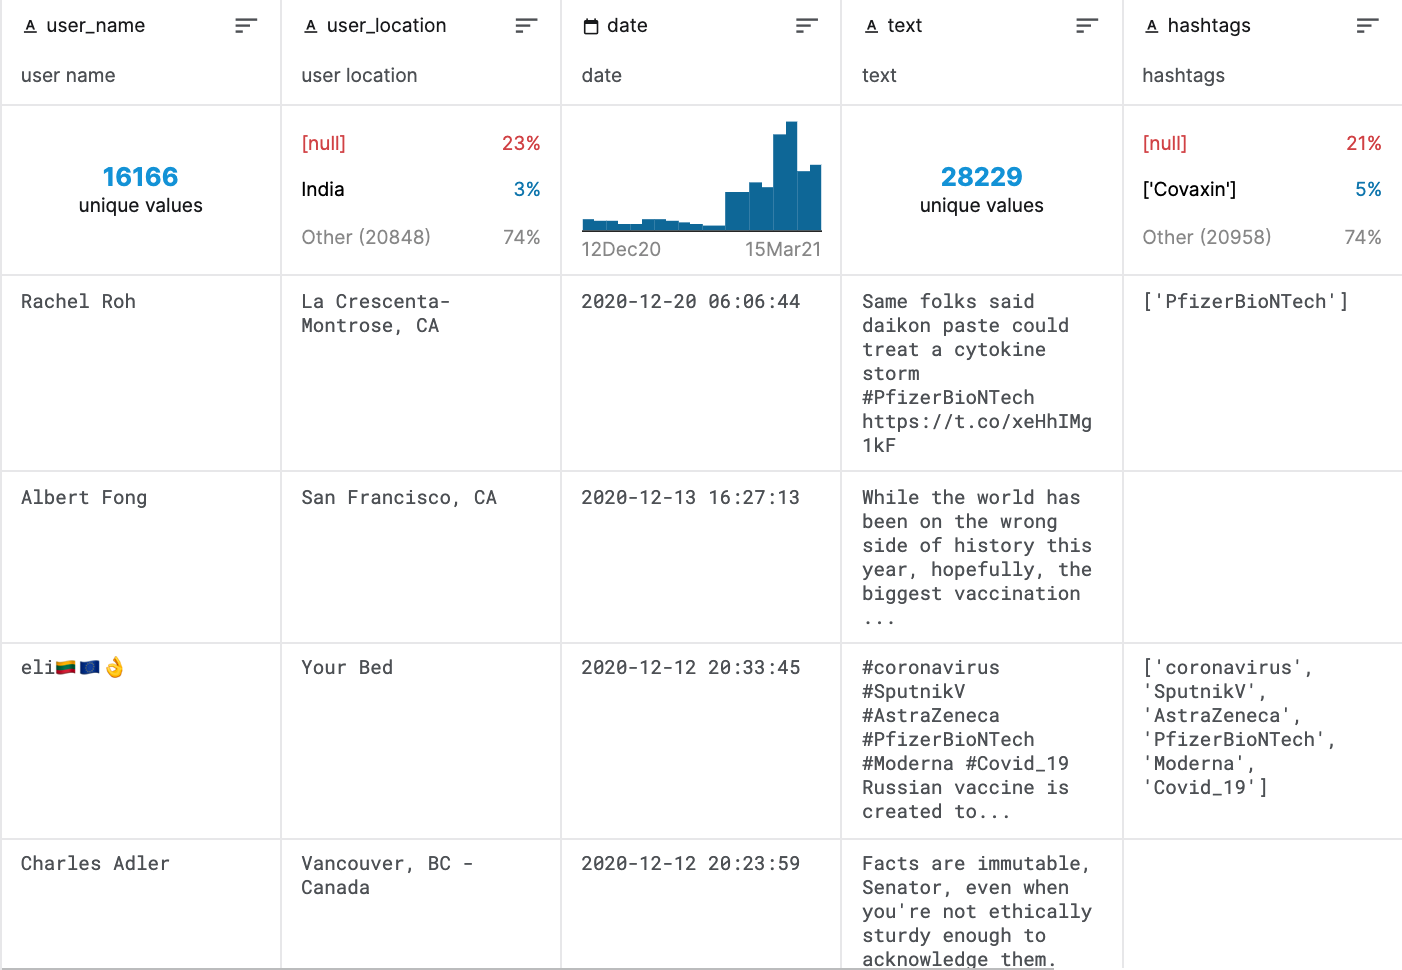

In [ ]:
####################################################################
#              author:     Sejal Dua                                                                                       #
#                 date:     03/15/2021                                                                                    #
#     data source:     https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets    #
#             credits:     Ariwan Sri Setya, Tom Whelan, Gabriel Preda                              #
####################################################################

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

# Data Access

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/DS4B/Class-Files/main/vaccination_all_tweets.csv", quotechar='"', delimiter=',').dropna()
df

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False
10,1337841934170255365,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27802,1368226947822653442,Andy The legally and popularly elected Gardener.,Untidied States,merciless infj door slammer.,2019-01-01 23:12:42,93,83,9876,False,2021-03-06 15:48:19,If you want to know how much antivaxx disinfor...,['SputnikV'],Twitter for iPhone,0,1,False
27804,1368224770995675139,🌎 Sarwar 🌐,E,W pirsarwarras,2009-07-01 00:18:11,1685,1439,6268,False,2021-03-06 15:39:40,#BREAKING \n#Venezuela \nVenezuelan President ...,"['BREAKING', 'Venezuela', 'SputnikV']",Twitter Web App,0,2,False
27806,1368224272267829256,Workout Solutions,"Toronto, Canada and Worldwide",George Tsanis – Workout Solutions Health and F...,2010-09-20 17:01:08,1164,172,1358,False,2021-03-06 15:37:41,Moscow Russia everything is open business as u...,['COVID19'],Twitter for iPhone,1,2,False
27807,1368218905353859081,William Owen,"Moscow, Russia",| political | cats | bikes | civil rights | te...,2009-03-16 03:03:13,3962,2594,51923,False,2021-03-06 15:16:21,Of course Black (spits) never mentions #Sputni...,"['SputnikV', 'ForbiddenVaccine']",Twitter Web App,0,0,False


In [ ]:
print(df.columns)
print(df.shape)

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')
(16180, 16)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16180 entries, 0 to 27808
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                16180 non-null  int64 
 1   user_name         16180 non-null  object
 2   user_location     16180 non-null  object
 3   user_description  16180 non-null  object
 4   user_created      16180 non-null  object
 5   user_followers    16180 non-null  int64 
 6   user_friends      16180 non-null  int64 
 7   user_favourites   16180 non-null  int64 
 8   user_verified     16180 non-null  bool  
 9   date              16180 non-null  object
 10  text              16180 non-null  object
 11  hashtags          16180 non-null  object
 12  source            16180 non-null  object
 13  retweets          16180 non-null  int64 
 14  favorites         16180 non-null  int64 
 15  is_retweet        16180 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.9+ MB


# Data Wrangling & Preprocessing

In [ ]:
df = df[['user_location', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'text', 'hashtags', 'source', 'retweets', 'favorites', 'is_retweet']]

In [ ]:
df = df.drop_duplicates('text')
print(df.shape)

(16170, 12)


In [ ]:
# use regular expressions to strip each tweet of mentions, hashtags, retweet information, and links
def clean_tweet_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = text.lower()
    return text

# the following line makes use of an apply function-- it will call clean_tweet_text on every element in the 'text' column
df['text'] = df['text'].apply(lambda x: clean_tweet_text(x))
df.head()

,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,"La Crescenta-Montrose, CA",405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,Your Bed,10,88,155,False,2020-12-12 20:33:45,coronavirus sputnikv astrazeneca pfizerbiontec...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
6,"Austria, Ukraine and Kosovo",2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
9,Islamabad,671,2368,20469,False,2020-12-12 19:30:33,covidvaccine \n\nstates will start getting cov...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False
10,Turkey-Israel,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False


In [ ]:
# we do not care about the exact time of each tweet, we just want the date
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()

,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,"La Crescenta-Montrose, CA",405,1692,3247,False,2020-12-20,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,Your Bed,10,88,155,False,2020-12-12,coronavirus sputnikv astrazeneca pfizerbiontec...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
6,"Austria, Ukraine and Kosovo",2731,5001,69344,False,2020-12-12,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
9,Islamabad,671,2368,20469,False,2020-12-12,covidvaccine \n\nstates will start getting cov...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False
10,Turkey-Israel,1302,78,339,False,2020-12-12,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False


# Exploratory Data Analysis (EDA)

In [ ]:
df.describe()

,user_followers,user_friends,user_favourites,retweets,favorites
count,1.617000e+04,16170.000000,16170.000000,16170.000000,16170.000000
mean,1.719752e+05,1518.035931,14619.516079,4.241187,18.428386
std,1.141814e+06,7640.144298,37054.083845,45.617605,246.240119
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2.180000e+02,170.000000,426.000000,0.000000,0.000000
50%,9.470000e+02,492.500000,2377.000000,0.000000,1.000000
75%,4.284000e+03,1372.750000,11847.250000,1.000000,5.000000
max,1.486666e+07,380428.000000,686342.000000,2360.000000,22815.000000


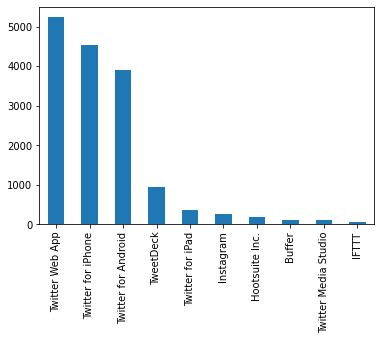

In [ ]:
# which device are people tweeting about the vaccine from?
df['source'].value_counts().head(n=10).plot.bar()

## TODO: your turn! do some EDA!

# Sentiment Analysis

We will be using the `TextBlob` library to perform sentiment analysis on the tweets in our dataset. `TextBlob` provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more. That said, there are numerous other packages with similar capabilities that are worth exploring, including `sklearn`, `nltk`, `vader`, and more.

In [ ]:
from textblob import TextBlob

In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


Let's do a simple example!

In [ ]:
# tweet from Texas Governor Greg Abbott
text = """
Today Texas surpassed 8 million vaccinations. It was just 4 days ago that we passed 7 million.

The positivity rate dropped even lower--to 6.08%--the lowest since May 31st.

Hospitalizations went down again also.

Great job Texans!

Vaccines are always voluntary, never forced.
"""
blob = TextBlob(text)

In [ ]:
print("Tags")
print(blob.tags, end="\n\n")

print("Noun Phrases")
print(blob.noun_phrases, end="\n\n")

print("Words")
print(blob.words, end="\n\n")

print("Sentences")
print(blob.sentences, end="\n\n")

Tags
[('Today', 'NN'), ('Texas', 'NNP'), ('surpassed', 'VBD'), ('8', 'CD'), ('million', 'CD'), ('vaccinations', 'NNS'), ('It', 'PRP'), ('was', 'VBD'), ('just', 'RB'), ('4', 'CD'), ('days', 'NNS'), ('ago', 'RB'), ('that', 'IN'), ('we', 'PRP'), ('passed', 'VBD'), ('7', 'CD'), ('million', 'CD'), ('The', 'DT'), ('positivity', 'NN'), ('rate', 'NN'), ('dropped', 'VBD'), ('even', 'RB'), ('lower', 'JJR'), ('to', 'TO'), ('6.08', 'CD'), ('%', 'NN'), ('the', 'DT'), ('lowest', 'JJS'), ('since', 'IN'), ('May', 'NNP'), ('31st', 'CD'), ('Hospitalizations', 'NNS'), ('went', 'VBD'), ('down', 'RB'), ('again', 'RB'), ('also', 'RB'), ('Great', 'NNP'), ('job', 'NN'), ('Texans', 'NNPS'), ('Vaccines', 'NNS'), ('are', 'VBP'), ('always', 'RB'), ('voluntary', 'JJ'), ('never', 'RB'), ('forced', 'VBN')]

Noun Phrases
['texas', 'positivity rate', 'may', 'hospitalizations', 'great job', 'vaccines']

Words
['Today', 'Texas', 'surpassed', '8', 'million', 'vaccinations', 'It', 'was', 'just', '4', 'days', 'ago', 'that'

In [ ]:
for sentence in blob.sentences:
    print(sentence)
    print("polarity:", sentence.sentiment.polarity)
    print("subjectivity:", sentence.sentiment.subjectivity)
    print()


Today Texas surpassed 8 million vaccinations.
polarity: 0.0
subjectivity: 0.0

It was just 4 days ago that we passed 7 million.
polarity: 0.0
subjectivity: 0.0

The positivity rate dropped even lower--to 6.08%--the lowest since May 31st.
polarity: 0.0
subjectivity: 0.0

Hospitalizations went down again also.
polarity: -0.15555555555555559
subjectivity: 0.2888888888888889

Great job Texans!
polarity: 1.0
subjectivity: 0.75

Vaccines are always voluntary, never forced.
polarity: 0.15000000000000002
subjectivity: 0.2



Analyze the above results from our TextBlob API calls:

*   Which sentence was most subjective?
*   Which sentence was most objective?
*   Which sentence was the most negatively charged?
*   Which sentence was the most positively charged?

Do these findings make sense?

### TODO: comment here

In [ ]:
blob = TextBlob(input("Now you try entering some text: "))
print(blob.sentiment)

Now you try entering some text: the food is gross
Sentiment(polarity=0.0, subjectivity=0.0)


In [ ]:
# let's apply the TextBlob API onto our tweet data to perform sentiment analysis!
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df.head()

,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,polarity,subjectivity
0,"La Crescenta-Montrose, CA",405,1692,3247,False,2020-12-20,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,0.00,0.125000
2,Your Bed,10,88,155,False,2020-12-12,coronavirus sputnikv astrazeneca pfizerbiontec...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,0.00,0.033333
6,"Austria, Ukraine and Kosovo",2731,5001,69344,False,2020-12-12,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False,-0.10,0.500000
9,Islamabad,671,2368,20469,False,2020-12-12,covidvaccine \n\nstates will start getting cov...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False,0.00,0.000000
10,Turkey-Israel,1302,78,339,False,2020-12-12,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False,0.25,0.333333


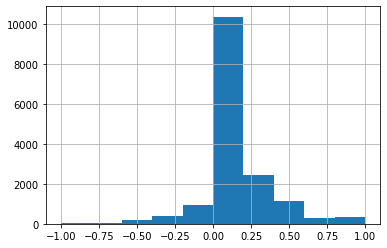

In [ ]:
df['polarity'].hist()

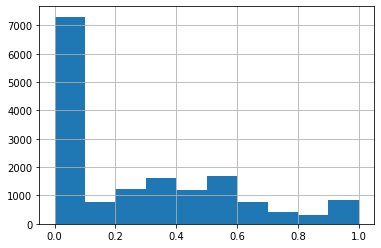

In [ ]:
df['subjectivity'].hist()

## TODO: Inspection

In [ ]:
# inspect the most negatively charged tweets
for i, tweet in enumerate(df[df['polarity'] <= -0.90]['text']):
  print(i, tweet)
  if i > 50:
    break

0 they are getting so desperate!! nothing in the 💉 medicaltyranny pseudoepidemic covid19 scientificdictatorship… 
1 be scared. be fearful. be petrified. take the shot. usa us covid19 covidiot pfizerbiontech pfizerbiotech… 
2 pfizerbiontech vaccin covid19 moderna 
what the fuck !!!!!!
😂😂😂😂🤣🤣🤣🤣🤣😱😱😱😱😱 
3 death of 23 people's in norway after receiving pfizerbiontech vaccine is pathetic and scarry too!! autopsy report… 
4 pharmaceutical greed at its worst...

pfizerbiontech 


5 got my moderna covid-19 vaccine dose 2 yesterday and today i feel like crap! 🤕 i do feel blessed to have had the o… 
6   get me sputnikv then we'll talk... otherwise jog on with your pathetic vaccine that does t wo… 
7 moderna 2 is done! 💉 so blessed to be fully vaccinated against this devastating virus. vaccinated 500kdeaths covid19 moderna
8 has anybody got the moderna vaccine? i'm scheduled for it friday &amp; i'm worried about feeling cruddy on bernie's bi… 
9 prime moron.

terrible advertisement for research in

In [ ]:
# TODO: you inspect the most positively charged tweets

In [ ]:
# TODO: you inspect the most subjective tweets
# Hint: the subjectivity scale ranges from 0 to 1

In [ ]:
# TODO: you inspect the most objective tweets

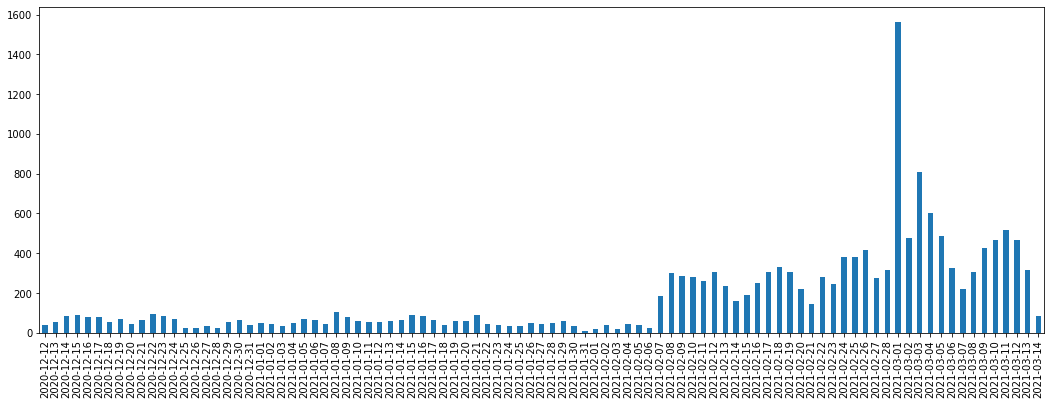

In [ ]:
# let's inspect how many tweets there were with respect to time
plt.figure(figsize=(18, 6))
df['date'].value_counts(sort=False).sort_index().plot.bar();
plt.xticks(rotation=90)
plt.show()

## TODO: Observe the graph above and write down 1-2 insights

# Time-Series Sentiment Analysis

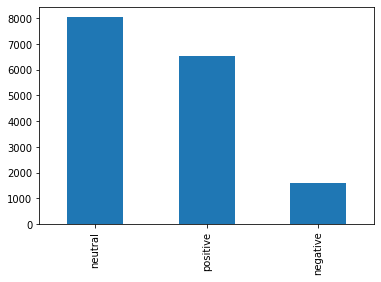

In [ ]:
# polarity values ranging from -1 to 1 are really useful for sentiment analysis
# but let's convert our data to 3 classes (negative, neutral, and positive) so that we can visualize it
criteria = [df['polarity'].between(-1, -0.01), df['polarity'].between(-0.01, 0.01), df['polarity'].between(0.01, 1)]
values = ['negative', 'neutral', 'positive']
df['sentiment'] = np.select(criteria, values, 0)

# plot sentiment counts
df['sentiment'].value_counts().plot.bar()

In [ ]:
# Get counts of number of tweets by sentiment for each date
timeline = df.groupby(['date', 'sentiment']).count().reset_index()
timeline['count'] = timeline['text']
timeline = timeline[['date', 'sentiment', 'count']]
timeline

,date,sentiment,count
0,2020-12-12,negative,4
1,2020-12-12,neutral,23
2,2020-12-12,positive,11
3,2020-12-13,negative,8
4,2020-12-13,neutral,27
...,...,...,...
274,2021-03-13,neutral,141
275,2021-03-13,positive,131
276,2021-03-14,negative,11
277,2021-03-14,neutral,44


In [ ]:
timeline = df.groupby(['date']).agg(np.nanmean).reset_index()
timeline['count'] = df.groupby(['date']).count().reset_index()['retweets']
timeline = timeline[['date', 'count', 'polarity', 'retweets', 'favorites', 'subjectivity']]
timeline["polarity"] = timeline["polarity"].astype(float)
timeline["subjectivity"] = timeline["subjectivity"].astype(float)
timeline

,date,count,polarity,retweets,favorites,subjectivity
0,2020-12-12,38,0.034952,0.631579,2.868421,0.227801
1,2020-12-13,52,0.055937,1.942308,7.500000,0.255696
2,2020-12-14,83,0.116874,4.698795,29.204819,0.267803
3,2020-12-15,87,0.094041,1.022989,7.333333,0.258078
4,2020-12-16,78,0.104020,1.000000,5.115385,0.248872
...,...,...,...,...,...,...
88,2021-03-10,465,0.098784,2.481720,9.987097,0.246851
89,2021-03-11,516,0.081946,2.232558,9.248062,0.253772
90,2021-03-12,467,0.108128,1.391863,8.509636,0.259496
91,2021-03-13,315,0.088139,3.161905,11.838095,0.290425


In [ ]:
# Plot results
import plotly.express as px
fig = px.bar(timeline, x='date', y='count', color='polarity')
fig.show()

# Filter by Vaccy

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine-- not very helpful!
def filter_by_vaccy(df, vax):
    df_filt = pd.DataFrame()
    for v in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(v)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date']).agg(np.nanmean).reset_index()
    timeline['count'] = df_filt.groupby(['date']).count().reset_index()['retweets']
    timeline = timeline[['date', 'count', 'polarity', 'retweets', 'favorites', 'subjectivity']]
    timeline["polarity"] = timeline["polarity"].astype(float)
    timeline["subjectivity"] = timeline["subjectivity"].astype(float)
    return df_filt, timeline

pfizy_df, pfizy_timeline = filter_by_vaccy(df, ['pfizer'])
pfizy_df

,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,polarity,subjectivity,sentiment
30,London,1151,4301,95963,False,2020-12-12,"6 deaths so far. \nit's only death, nothing t...","['CovidVaccines', 'Pfizervaccine']",Twitter for Android,0,2,False,0.050000,1.000000,positive
57,"LI, NYC, NJ, PA, NE, USA",24686,6077,2994,False,2020-12-14,members of the delivered the first covid19vac...,"['COVID19Vaccine', 'teamsters', 'UPS', 'COVID1...",Twitter Web App,8,18,False,0.250000,0.333333,positive
94,India,16816,2448,20,False,2020-12-14,toronto to receive ontario's 1st doses of pfiz...,['Ontario'],Twitter Web App,0,0,False,0.000000,0.000000,neutral
128,"Mumbai, India",67096,344,118,True,2020-12-14,"singapore approves pfizer covid19 vaccine, fir...","['Singapore', 'COVID19', 'December']",Twitter Web App,0,2,False,0.075000,0.366667,positive
206,"DC, Baltimore, New Orleans",2981,2236,494,False,2020-12-13,redfield has just signed off on this recommen...,"['CDC', 'Pfizer', 'COVID19', 'Vaccine']",Twitter Web App,0,1,False,0.000000,0.000000,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,"B More, Musicland, Amerryca!",99,137,707,False,2021-03-07,that second shot of pfizer built my confidence...,"['Pfizer', 'COVID19']",Twitter Web App,0,0,False,0.000000,0.000000,neutral
25417,"Miami, QLD Australia",378,267,3165,False,2021-03-07,please share widely \n\nvideo : 👉 \nwebsite : ...,"['documentary', 'Pfizer']",Twitter Web App,0,0,False,-0.050000,0.200000,negative
25478,Seattle area,3148,3836,1380,False,2021-03-06,adverse incident reports show 966 deaths follo...,"['Deaths', 'Vaccination', 'COVID19', 'Pfizer']",Twitter Web App,0,0,False,0.000000,0.100000,neutral
25609,US,1613,1971,9125,False,2021-03-06,soon we all should have the choice available t...,"['vaccination', 'PfizerVaccine']",Twitter for Android,0,0,False,0.400000,0.400000,positive


In [ ]:
import plotly.express as px
fig = px.bar(pfizy_timeline, x='date', y='count', color='polarity')
fig.show()

In [ ]:
# copy the two cells above to do the same exploration of moderna tweets

# Wordclouds

In [ ]:
!pip install wordninja
!pip install pyspellchecker

     |████████████████████████████████| 542kB 4.4MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp37-none-any.whl size=541554 sha256=2fd2d806ff9e5c386475950a193a3721892b77b28b738f29d57300d53a2479ac
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja
     |████████████████████████████████| 2.7MB 4.2MB/s 


In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import wordninja
from spellchecker import SpellChecker
from collections import Counter
import nltk
import math
import random
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))  
stop_words.add("amp")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Simple

(-0.5, 999.5, 499.5, -0.5)

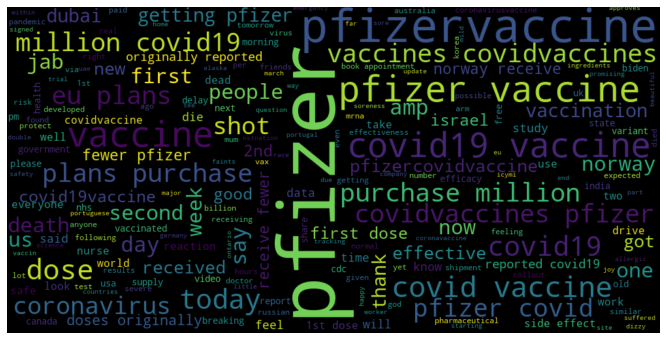

In [ ]:
tweet_df = pfizy_df
words = ' '.join([word for word in tweet_df['text']])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)

fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

### TODO: take this word cloud to the next level


*   play around with the arguments in this line of code `word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)
` that influence the wordcloud above 
*   make a wordcloud for tweets about the moderna vaccine
*  see if you can color code the words by their sentiment / polarity scores



## Advanced

In [ ]:
def flatten_list(l):
    return [x for y in l for x in y]

def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

# Color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

# Reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(1,3, figsize=(20,10))
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Words")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

def get_top_percent_words(doc, percent):
    # Returns a list of "top-n" most frequent words in a list 
    top_n = int(percent * len(set(doc)))
    counter = Counter(doc).most_common(top_n)
    top_n_words = [x[0] for x in counter]
    # print(top_n_words)
    return top_n_words
    
def clean_document(doc):
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words (needed for calculating frequencies correctly )
    doc = [lemmatizer.lemmatize(x) for x in doc]
    
    # Get the top 10% of all words. This may include "misspelled" words 
    top_n_words = get_top_percent_words(doc, 0.1)

    # Get a list of misspelled words 
    misspelled = spell.unknown(doc)
    
    # Accept the correctly spelled words and top_n words 
    clean_words = [x for x in doc if x not in misspelled or x in top_n_words]
    
    # Try to split the misspelled words to generate good words (ex. "lifeisstrange" -> ["life", "is", "strange"])
    words_to_split = [x for x in doc if x in misspelled and x not in top_n_words]
    split_words = flatten_list([wordninja.split(x) for x in words_to_split])
    
    # Some splits may be nonsensical, so reject them ("llouis" -> ['ll', 'ou', "is"])
    clean_words.extend(spell.known(split_words))
    
    return clean_words

def get_log_likelihood(doc1, doc2):    
    doc1_counts = Counter(doc1)
    doc1_freq = {
        x: doc1_counts[x]/len(doc1)
        for x in doc1_counts
    }
    
    doc2_counts = Counter(doc2)
    doc2_freq = {
        x: doc2_counts[x]/len(doc2)
        for x in doc2_counts
    }
    
    doc_ratios = {
        # 1 is added to prevent division by 0
        x: math.log((doc1_freq[x] +1 )/(doc2_freq[x]+1))
        for x in doc1_freq if x in doc2_freq
    }
    
    top_ratios = Counter(doc_ratios).most_common()
    top_percent = int(0.1 * len(top_ratios))
    return top_ratios[:top_percent]

# Function to generate a document based on likelihood values for words 
def get_scaled_list(log_list):
    counts = [int(x[1]*100000) for x in log_list]
    words = [x[0] for x in log_list]
    cloud = []
    for i, word in enumerate(words):
        cloud.extend([word]*counts[i])
    # Shuffle to make it more "real"
    random.shuffle(cloud)
    return cloud

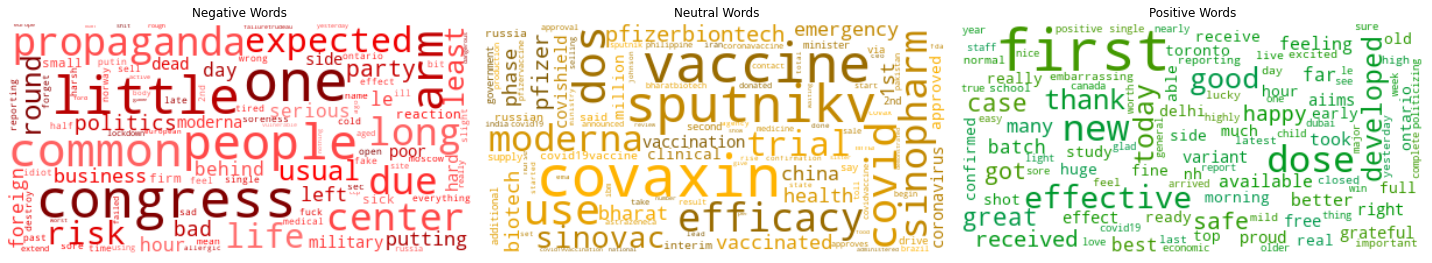

In [ ]:
def get_smart_clouds(df):

    neg_doc = flatten_list(df[df['sentiment']=='negative']['words'])
    neg_doc = [x for x in neg_doc if is_acceptable(x)]

    pos_doc = flatten_list(df[df['sentiment']=='positive']['words'])
    pos_doc = [x for x in pos_doc if is_acceptable(x)]

    neu_doc = flatten_list(df[df['sentiment']=='neutral']['words'])
    neu_doc = [x for x in neu_doc if is_acceptable(x)]

    # Clean all the documents
    neg_doc_clean = clean_document(neg_doc)
    neu_doc_clean = clean_document(neu_doc)
    pos_doc_clean = clean_document(pos_doc)

    # Combine classes B and C to compare against A (ex. "positive" vs "non-positive")
    top_neg_words = get_log_likelihood(neg_doc_clean, flatten_list([pos_doc_clean, neu_doc_clean]))
    top_neu_words = get_log_likelihood(neu_doc_clean, flatten_list([pos_doc_clean, neg_doc_clean]))
    top_pos_words = get_log_likelihood(pos_doc_clean, flatten_list([neu_doc_clean, neg_doc_clean]))

    # Generate syntetic a corpus using our loglikelihood values 
    neg_doc_final = get_scaled_list(top_neg_words)
    neu_doc_final = get_scaled_list(top_neu_words)
    pos_doc_final = get_scaled_list(top_pos_words)

    # Visualise our synthetic corpus
    generate_word_clouds(neg_doc_final, neu_doc_final, pos_doc_final)
    
# Convert string to a list of words
wordcloud_df = df
wordcloud_df['words'] = wordcloud_df.text.apply(lambda x:re.findall(r'\w+', x ))
get_smart_clouds(wordcloud_df)

# Insert Cool Sh!t Here

If you wish to go on beyond the scope of this notebook, this is the place to do it. Ideas for extension projects:


*   Use the  `tweepy` [API](https://docs.tweepy.org/en/latest/) to get tweets about the Johnson & Johnson Vaccine, and apply your sentiment analysis onto them.
*   Make some of these visualizations better.
*   Do a quick analysis of hashtag usage
*   What are verified Twitter users saying about the COVID-19 vaccine?
*   What are people saying with respect to side effects? How could you filter the dataset to examine this subtopic?
*   Correlate the [COVID-19 World Vaccination Progress dataset](https://www.kaggle.com/gpreda/covid-world-vaccination-progress) with your sentiment analysis to monitor how attitudes are changing towards the vaccine as the rollout continues.
*   If you know any ML techniques, try to make a model! Then tell us what you did!

